# An example for GPinv.linear_model

This notebook briefly shows an inference example for non-linear model

*Keisuke Fujii 5th Sept. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=cylindrical.png>

The local emission intensity $f$ is a function of the radius $r$.
The observed emission intensity $\mathbf{T}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} g(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $g$ into $n$ discrete points $\mathbf{f}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{g} + \mathbf{e}
$$

## Non-linear model

We assume 
$$
g(r) = \exp(f(r))
$$
where $f(r)$ follows the Gaussian Process with kernel $\mathrm{K}$, 
for satisfying the positive solution of $\mathbf{g}$.

Therefore, this problem is non-linear.

In this notebook, we estimate $\mathbf{g}$ by MCMC.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('../testing/')
from test_linear_model import make_LosMatrix

## Latent functions

In [2]:
n = 30
N = 40
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

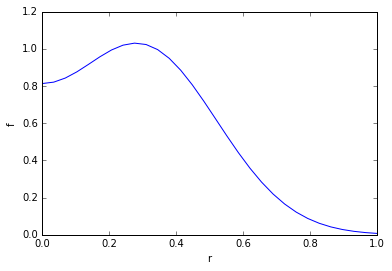

In [3]:
# plotting the latent function
plt.plot(r, f)
plt.xlabel('r')
plt.ylabel('f')

## Synthetic experiment

In [37]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix(r, z)

In [38]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * np.random.randn(N)

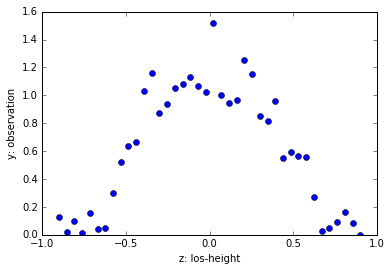

In [39]:
plt.plot(z, y, 'o', [-1,1],[0,0], '--k')
plt.xlabel('z: los-height')
plt.ylabel('y: observation')

# Inference

In [7]:
import GPinv

## Likelihood

For tackling this non-linear model, we need to construct a custom-likelihood to express $p(\mathbf{Y}|\mathbf{g})$.

In [8]:
import tensorflow as tf

class AbelLikelihood(GPinv.likelihoods.StochasticLikelihood):
    def __init__(self, Amat, num_stocastic_points=20):
        GPinv.likelihoods.StochasticLikelihood.__init__(self, num_stocastic_points)

        self.Amat = GPinv.param.DataHolder(Amat)
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)

    def logp(self, X, Y):
        """
        :param list of tensor Xlist: tensor for the latent function.
                The shape of the i-th element is [Ni,M]
        :param list of tensor Ylist: tensor for the observation.
                The shape of the i-th element is [Ni',M]
        :return list of log of the likelihood with length P.
            The shape should be the same to that of Ylist.
        """
        F = tf.matmul(self.Amat, tf.exp(X))
        return GPinv.densities.gaussian(F, Y, self.variance)

## Kernel

We need small jitter for the numericall stability.

In [40]:
kern = GPinv.kernels.RBF_csym(1)
kern_jitter = GPinv.kernels.White(1)
# jitter variance
kern_jitter.variance = 1.0e-4

### Defining MCMC model (GPMC)

In [41]:
model_mc = GPinv.nonlinear_model.GPMC(r.reshape(-1,1), y.reshape(-1,1), 
                                   kern = kern + kern_jitter, # jitter is necessary for MCMC
                                   mean_function = GPinv.mean_functions.Constant(np.ones(1)),
                                   likelihood=AbelLikelihood(A))

In [42]:
model_mc.likelihood.variance=0.1

In [43]:
# sampling
samples = model_mc.sample(500, burn=400, verbose=True)

compiling tensorflow function...
done
burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  97.0 %
Iteration:  400 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  97.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  94.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  97.0 %


### VGP

In [73]:
model_vgp = GPinv.vgp.VGP(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = kern,
                           mean_function = GPinv.mean_functions.Constant(np.ones(1)),
                           likelihood=AbelLikelihood(A, 40))

In [74]:
model_vgp.likelihood.variance=0.1
model_vgp.kern.variance=1
model_vgp.kern.lengthscales=0.1

In [71]:
model_vgp.optimize(maxiter=300)

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: 14.733422733063687
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.16647592e+00,   6.42834603e+00,   7.14332192e+00,
         8.11860334e+00,   9.09081525e+00,   9.79488978e+00,
         1.00306852e+01,   9.70968447e+00,   8.87094498e+00,
         7.66439327e+00,   6.30793183e+00,   5.03108743e+00,
         4.02108250e+00,   3.38610204e+00,   3.14458696e+00,
         3.24018758e+00,   3.57342673e+00,   4.03704842e+00,
         4.54364282e+00,   5.03935071e+00,   5.50295948e+00,
         5.93351096e+00,   6.33170089e+00,   6.68174176e+00,
         6.94100690e+00,   7.04340966e+00,   6.91785362e+00,
         6.51598482e+00,   5.83736521e+00,   4.93942367e+00,
         1.32141353e-01,   1.25633445e-01,  -1.98416517e-02,
        -4.17544183e-01,  -8.99784110e-01,  -1.14879844e+00,
        -1.15579580e+00,  -1.06487616e+00,  -8.62537829e-01,
        -5.90180436e-01,  -3.30193558e-01,  -1.60055316e-01,
        -7.77001829e-02,  -9.68134915e-02,  -1.

In [75]:
# optimizing
_ = model_vgp.optimize(tf.train.AdamOptimizer(learning_rate=0.01), maxiter=500)

compiling tensorflow function...
done


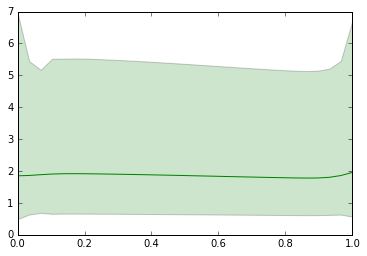

In [76]:
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='vgp')

## Predicting the latent functions

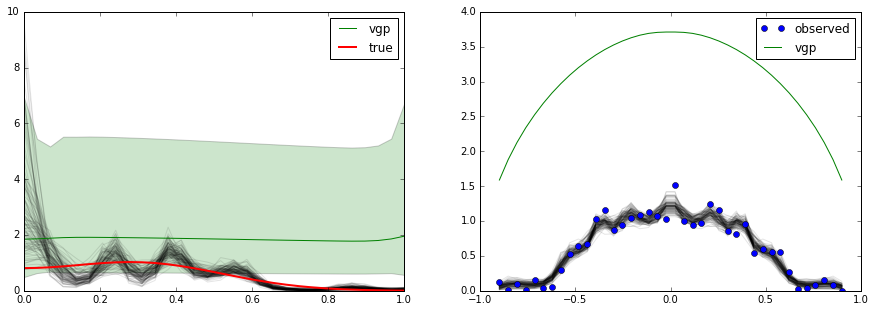

In [48]:
r_new = np.linspace(0.,1., 30)

plt.figure(figsize=(15,5))
for s in samples[::5]:
    model_mc.set_state(s)
    f_pred = model_mc.predict_f(r_new.reshape(-1,1))
    plt.subplot(1,2,1)
    plt.plot(r_new, np.exp(f_pred[0]),'k', alpha=0.1)
    plt.subplot(1,2,2)
    plt.plot(z, np.dot(A, np.exp(f_pred[0])),'k', alpha=0.1)

plt.subplot(1,2,1)
f_pred, f_var = model_vgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='vgp')
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z, y, 'bo',lw=2, label='observed')
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'g', label='vgp')
plt.legend()